# Network and Vertex feature joint representation learning

In many network problems, we might have access to much more information than just the 
collection of nodes and edges in the network. If we were investigating a social 
network, for instance, we might have access to extra information about each 
person -- their gender, for instance, or their age. If we were investigating a brain network, we might have information about the physical location of neurons, or the volume of a brain region. When we we embed a network, it seems 
like we should be able to use these extra bits of information - called "features" or "covariates" - to somehow improve our analysis.
Many of the techniques and tools that we'll explore in this section use both the covariates and the network to 
learn from new, holistic representations of the data available to us, jointly using both the network and the covariates.
These techniques are called joint representation learning.

There are two primary reasons that we might want to explore using node covariates in addition to networks. Firstly, they might improve our 
standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. 
For example, if the latent structure of the covariates lines up with the latent structure
of our network, then we could conceivably reduce noise, even if the communities in our network don't don't overlap perfectly with the communities in our covariates. Second,
figuring out what the clusters of an embedding actually mean can sometimes be difficult. Using covariates
gives us to access to a natural structure. Covariate information telling us a location in the brain and name of brain region for each node in brain networks, for instance, might let us better
cluster by region.

In this section, we'll explore different ways to learn from our data when we have access to these covariates in addition to our network. We'll learn by example by making a toy network with its covariates.  
We'll then explore *Covariate-Assisted Spectral Embedding* (CASE), a variation on spectral embedding. In CASE, instead of embedding the adjacency matrix or one of the many versions of the Laplacian, we'll combine the laplacian and our covariates into a new matrix and embed that.

## Making a Model

The best way to illustrate how using covariates might help us is to use a model in which some of our community information is in the covariates, and some is in our network. Making a toy network is pretty easy for us at this point - we already have tools for simulating different networks, and so we'll just use our go-to: the ever-popular Stochastic Block Model (SBM). We'll use a 3-block structure: the first and second block will be hard to separate in the network itself, and the second and third block will be hard to separate in our covariates. By combining the network and the covariates, we get a nice embedding that lets us find three distinct community clusters.

### Stochastic Block Model

The first two communities of our SBM will be extremely similar, whereas the third will be distinct.

In [2]:
import warnings
warnings.filterwarnings("ignore")  # TODO: don't do this, fix scatterplot

In [3]:
import numpy as np
from graspologic.simulations import sbm
from graspologic.plot import heatmap

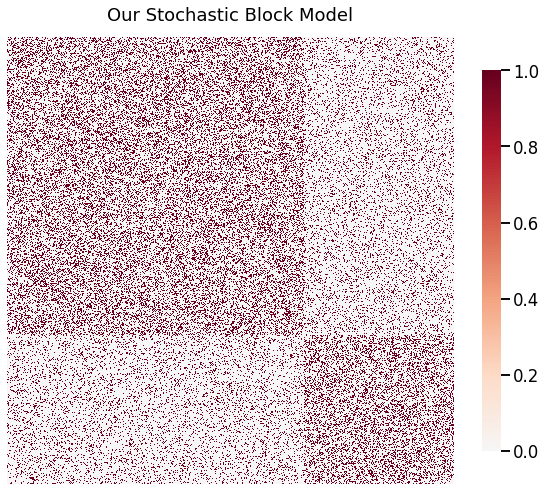

In [4]:
# Start with some simple parameters
N = 1500  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[.3, .3, .15],
              [.3, .3, .15],
              [.15, .15, .3]])  # Our block probability matrix

# Make and visualize our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)
heatmap(A, title="Our Stochastic Block Model");

### Covariates

Now, let's generate some covariates. Remember, each node is associated with its own group of covariates that provide information about the node. We'll organize these into a matrix, where each row contains the covariates associated with a particular node.  

To keep things simple, we'll have our covariates only take on true/false values - or, more specifically, 0 and 1. We'd also like a node's covariates to look different depending on which community it belongs to. To that end, we'll give each node 30 covariates, with the first ten having a higher probability of 1 in the first community, the second ten having a higher probability of 1 in the second community, and the third ten having a higher probability of 1 in the third community.

In [34]:
import numpy as np
from scipy.stats import bernoulli
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def gen_covariates(p1=.9, p2=.6, p3=.3, N=1500):
    """
    Generate a matrix of covariates.
    """
    n_covariates = 30

    bern = lambda p: bernoulli.rvs(p, size=(N//3, n_covariates//3))    
    X = np.block([[bern(p1), bern(p3), bern(p3)],
                  [bern(p3), bern(p2), bern(p2)],
                  [bern(p3), bern(p2), bern(p2)]])

    return X

# Generate a covariate matrix
X = gen_covariates(N=N)

You can see a visualization of the covariates below.

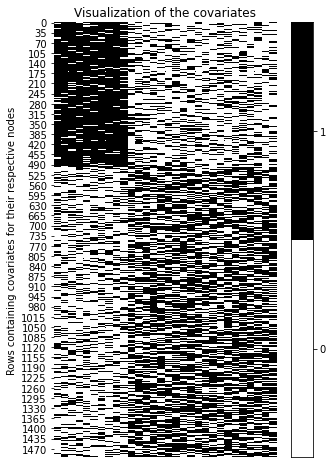

In [35]:
# Plot and make the axis look nice
fig, ax = plt.subplots(figsize=(5, 8))
colors = ["white", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
ax = sns.heatmap(X, cmap=cmap, ax=ax)
ax.set(title="Visualization of the covariates", xticks=[], 
       ylabel="Rows containing covariates for their respective nodes");

# make the colorbar look nice
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['0', '1'])
cbar.ax.set_frame_on(True)

## Covariate-Assisted Spectral Embedding

<i>Covariate-Assisted Spectral Embedding</i>, or CASE<sup>1</sup>, is a simple way of combining our graph and our covariates into a single model. In the most straightforward version of CASE, we use the graph's regularized Laplacian matrix $L$ and a function of our covariate matrix $XX^T$ (where $X$ is just our covariate matrix, in which row $i$ contains the covariates associated with node $i$). Notice the word "regularized" - This means (from the Laplacian section earlier) that we are using $L_{\tau} = D_{\tau}^{-1/2} A D_{\tau}^{-1/2}$.

```{note}
Remember that, in our case, $X$ only contains 0's and 1's. To interpret $XX^T$, remember from linear algebra that we're taking the weighted sum (or, in math parlance, the dot product) of each row with each other row, as shown below:

\begin{align}
\begin{bmatrix}
1 \\
1 \\
1 \\
\end{bmatrix} \cdot 
\begin{bmatrix}
0 \\
1 \\
1 \\
\end{bmatrix} = 1\times 0 + 1\times 1 + 1\times 1 = 2
\end{align}
```

If there are two overlapping 1's in the same column of rows $i$ and $j$, then their weighted sum will have a 1 in that place. The resulting value, $XX^T_{i, j}$ will be equal to the number of columns in which rows $i$ and $j$ both have ones. So, $XX^T_{i, j}$ can be interpreted as measuring the "agreement" between rows $i$ and row $j$. The result is a matrix that looks fairly similar to our Laplacian!  

The following Python code generates both matrices and visualizes them.

In [49]:
from graspologic.utils import to_laplacian
import matplotlib.pyplot as plt

L = to_laplacian(A, form="R-DAD")
XXt = X@X.T

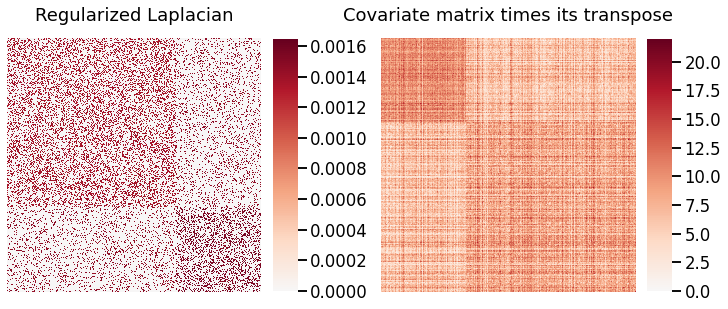

In [50]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)
L_ax = heatmap(L, title=r"Regularized Laplacian", ax=axs[0])
X_ax = heatmap(XXt, title="Covariate matrix times its transpose", ax=axs[1]);

CASE simply sums these two matrices together, using a weight for $XX^T$ so that they both contribute equally to the result. Here, we'll just use the ratio of the leading eigenvalues of our two matrices as our weight (henceforth known as $\alpha$). Later on, we'll explore ways to pick a better $\alpha$.

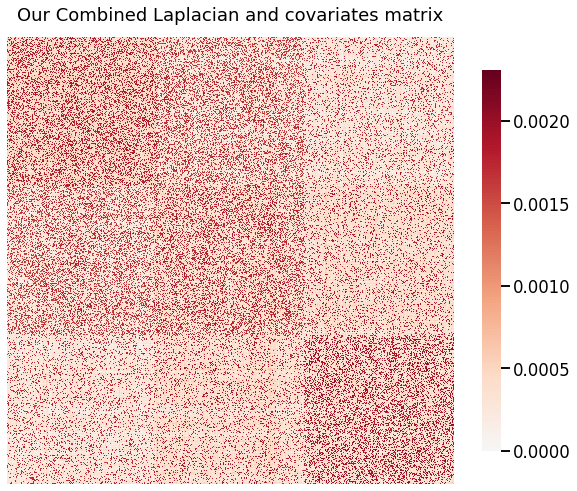

In [51]:
# Get a simple weight
L_eigvals = np.flip(np.linalg.eigvalsh(L))
XXt_eigvals = np.flip(np.linalg.eigvalsh(XXt))

# Ratio of the leading eigenvalues of L and XX^T
alpha = np.float(L_eigvals[0] / XXt_eigvals[0])

# Using our simple weight, combine our two matrices
L_ = L + alpha * X@X.T
heatmap(L_, title="Our Combined Laplacian and covariates matrix");

Everything works as usual from here: we decompose our matrix using an SVD, extracting the first three eigenvalues, and then we plot the rows to visualize our clustering.

In [67]:
from graspologic.embed import selectSVD
from graspologic.plot import pairplot
import scipy


def embed(A, *, dimension):
    latents, _, _ = scipy.linalg.svd(A)
    latents = latents[:, :dimension]
    return latents

latents = embed(L_, dimension=2)

Below, you can see three figures: the first is our embedding when we combine $XX^T$ and $$L$$, the second is our embedding when we only use $$L$$, and the third is our embedding when we only use $$XX^T$$.

<AxesSubplot:title={'center':'Latent positions when we combine\n our network and our covariates'}>

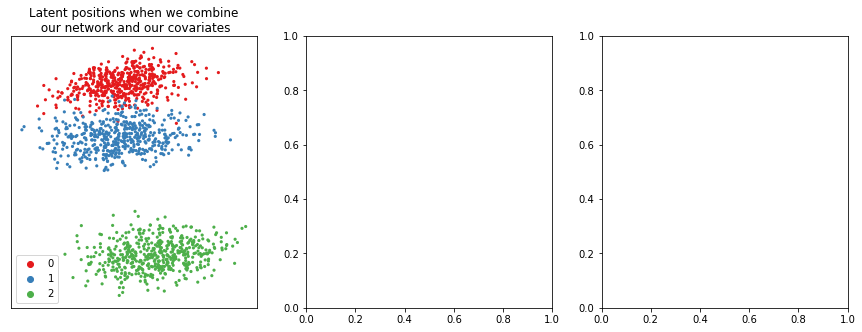

In [66]:
def plot_latents(latent_positions, *, title, labels, ax):
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           palette="Set1", linewidth=0, s=10, ax=ax)
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    return plot
    
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_latents(latents, title="Latent positions when we combine\n our network and our covariates", 
             labels=labels, ax=axs[0])



### Setting A Better Weight

Our simple choice of the ratio of leading eigenvalues for our weight $\alpha$ is straightforward, but we can probably do better. If our covariate matrix is crappy -- meaning, it doesn't tell us much about our communities -- we'd want a smaller weight so that our Laplacian is more emphasized when we embed. Similarly, if our Laplacian is crappy, we'd like a larger weight to emphasize the covariates.  

In general, we'd simply like to embed in a way that makes our clustering better - meaning, if we label our communities, we'd like to be able to correctly retrieve as many labels after the embedding as possible with a clustering algorithm, and for our clusters to be as distinct as possible.

One reasonable way to accomplish this goal is to simply find a range of possible $\alpha$ values, embed for every value in this range, and then to simply check which values produce the best clustering.

#### Getting the Range

For somewhat complicated linear algebra reasons<sup>1</sup>, it's fairly straightforward to get a range of tuning values: the minimum and maximum $\alpha$ is described by a set of two equations.

$\alpha_{min} = \frac{\lambda_K(L) - \lambda_{K+1}(L)}{\lambda_1(XX^T)}$ where $K$ is the number of embedding clusters, $\lambda_i(L)$ is the $i_{th}$ eigenvalue of $L$.

If the number of covariate dimensions is less than or equal to the number of clusters, then  
$\alpha_{max} = \frac{\lambda_1 (L)}{\lambda_R (XX^T)}$ where $R$ is the number of covariate dimensions

If the number of covariate dimensions is greater than the number of clusters, then  
$\alpha_{max} = \frac{\lambda_1(L)}{\lambda_K(XX^T) -\lambda_{K+1} (XX^T)}$

In [10]:
R = X.shape[1]  # Number of covariates
K = B.shape[0]  # Number of clusters

# Remember, Python uses 0-indexing!
amin = (L_eigvals[K-1] - L_eigvals[K]) / XXt_eigvals[0]
if R <= K:
    amax = L_eigvals[0] / XXt_eigvals[R-1]
elif R > K:
    amax = L_eigvals[0] / (XXt_eigvals[K-1] - XXt_eigvals[K])
    
print(f"Our minimum weight is {amin:.8f}.")
print(f"Our maximum weight is {amax:.8f}.")

Our minimum weight is 0.00000774.
Our maximum weight is 0.00042498.


#### K-Means

Let's try it out. Our clustering algorithm of choice will be scikit-learn's faster implementation of k-means. The K-means algorithm is a simple algorithm capable of clustering most datasets very quickly and efficiently, often in only a few iterations. It works by at first putting cluster centers in essentially random places, then iterating through a center-finding procedure until the cluster centers are in nice places. If you want more information, you can check out the original paper by Stuart Lloyd<sup>2</sup>.

We also need to define exactly what it means to check which values produce the best clustering. Fortunately, K-means comes out-of-the-box with exactly what we need: its objective function, the sum of squared distances of each point from its center. In KMeans, this is generally called the "inertia".

Our best alpha-value is 0.00000774


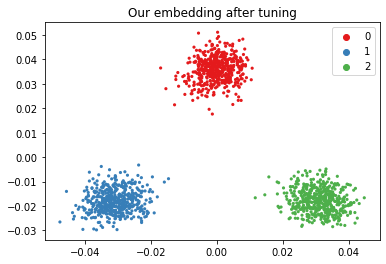

In [11]:
from sklearn.cluster import MiniBatchKMeans
import time

def cluster(alpha, L, XXt, *, n_clusters):
    L_ = L + alpha*XXt
    latents, _, _ = scipy.linalg.svd(L_)
    latents = latents[:, :n_clusters]
    return latents


start = time.perf_counter()
tuning_range = np.linspace(amin, amax, num=10)
alphas = {}
for alpha in tuning_range:
    L_ = L + alpha*XXt
    latents = embed(L_, n_clusters=K)
    kmeans = MiniBatchKMeans(n_clusters=K)
    kmeans.fit(latents)
    alphas[alpha] = kmeans.inertia_

best_alpha = min(alphas, key=alphas.get)
print(f"Our best alpha-value is {best_alpha:0.8f}")

latents = embed(L+best_alpha*XXt, n_clusters=K)
plot_latents(latents, title="Our embedding after tuning", labels=labels)

<AxesSubplot:>

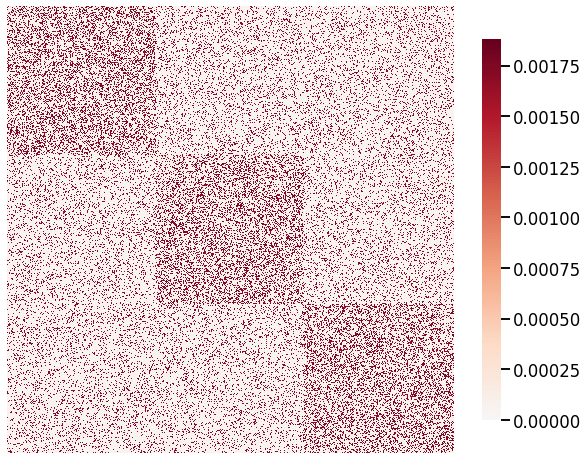

In [12]:
heatmap(L+best_alpha*XXt)

### Variations on CASE

There are situations where changing the matrix that you embed is useful. 

*non-assortative*  
If your graph is *non-assortative* - meaning, the between-block probabilities are greater than the within-block communities - it's better to square your Laplacian. You end up embedding $LL + aXX^T$.  

*big graphs*  
Since the tuning procedure is computationally expensive, you wouldn't want to spend the time tuning $\alpha$ for larger graphs. There are a few options here: you can use a non-tuned version of alpha, or you can use a variant on classical correlation analysis<sup>3</sup> and simply embed $LX$.

### Using Graspologic

Graspologic's CovariateAssistedSpectralEmbedding class uses SVD decomposition to implement CASE, just like we just did earlier. The following code applies CASE to reduce the dimensionality of $L + aXX^T$ down to three dimensions, and then plots the second dimension against the third to show the clustering. You can also try the above variations on CASE with the `embedding_alg` parameter.

amin=0.005519059, amax=0.297135065
alpha without tuning: 0.1314702072263226
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    9.7s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    9.7s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:   19.2s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:   1

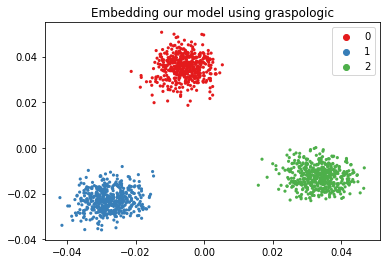

In [15]:
from graspologic.embed import CovariateAssistedEmbedding as CASE

casc = CASE(embedding_alg="assortative", n_components=3)
latents = casc.fit_transform(A, covariates=X)
plot_latents(latents, title="Embedding our model using graspologic", labels=labels)

#### References

[1] N. Binkiewicz, J. T. Vogelstein, K. Rohe, Covariate-assisted spectral clustering, Biometrika, Volume 104, Issue 2, June 2017, Pages 361–377, https://doi.org/10.1093/biomet/asx008  
[2] Lloyd, S. (1982). Least squares quantization in PCM. IEEE transactions on information theory, 28(2), 129-137.  
[3] Hotelling, H. (1936). Relations between two sets of variates. Biometrika 28, 321–77.